# Data preparation

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nltk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sns.set_style('whitegrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AB_US_2020.csv',
                 parse_dates=['last_review'],
                 low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [ ]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.260300e+05,2.260300e+05,226030.000000,226030.000000,226030.000000,2.260300e+05,226030.000000,177428.00000,226030.000000,226030.000000
mean,2.547176e+07,9.352385e+07,35.662829,-103.220662,219.716529,4.525490e+02,34.506530,1.43145,16.698562,159.314856
std,1.317814e+07,9.827422e+07,6.849855,26.222091,570.353609,2.103376e+05,63.602914,1.68321,51.068966,140.179628
min,1.090000e+02,2.300000e+01,18.920990,-159.714900,0.000000,1.000000e+00,0.000000,0.01000,1.000000,0.000000
25%,1.515890e+07,1.399275e+07,32.761783,-118.598115,75.000000,1.000000e+00,1.000000,0.23000,1.000000,0.000000
50%,2.590916e+07,5.138266e+07,37.261125,-97.817200,121.000000,2.000000e+00,8.000000,0.81000,2.000000,140.000000
75%,3.772624e+07,1.497179e+08,40.724038,-76.919322,201.000000,7.000000e+00,39.000000,2.06000,6.000000,311.000000
max,4.556085e+07,3.679176e+08,47.734620,-70.995950,24999.000000,1.000000e+08,966.000000,44.06000,593.000000,365.000000


In [ ]:
df.isna().sum()


id                                     0
name                                  28
host_id                                0
host_name                             33
neighbourhood_group               115845
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        48602
reviews_per_month                  48602
calculated_host_listings_count         0
availability_365                       0
city                                   0
dtype: int64

In [ ]:
print('neighbourhood_group column has',100*df.neighbourhood_group.isnull().sum()/df.shape[0],'% of NaNs \n'
    'last_review column has',100*df.last_review.isnull().sum()/df.shape[0],'% of NaNs \n'
    'reviews_per_month column has',100*df.reviews_per_month.isnull().sum()/df.shape[0],'% of NaNs')

neighbourhood_group column has 51.25204618855904 % of NaNs 
last_review column has 21.50245542627085 % of NaNs 
reviews_per_month column has 21.50245542627085 % of NaNs


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   host_id                         226030 non-null  int64  
 3   host_name                       225997 non-null  object 
 4   neighbourhood_group             110185 non-null  object 
 5   neighbourhood                   226030 non-null  object 
 6   latitude                        226030 non-null  float64
 7   longitude                       226030 non-null  float64
 8   room_type                       226030 non-null  object 
 9   price                           226030 non-null  int64  
 10  minimum_nights                  226030 non-null  int64  
 11  number_of_reviews               226030 non-null  int64  
 12  last_review     

In [ ]:
[(column, df[column].nunique()) for column in df.columns]

[('id', 226029),
 ('name', 218443),
 ('host_id', 130425),
 ('host_name', 30533),
 ('neighbourhood_group', 34),
 ('neighbourhood', 1450),
 ('latitude', 145091),
 ('longitude', 145243),
 ('room_type', 4),
 ('price', 1975),
 ('minimum_nights', 169),
 ('number_of_reviews', 660),
 ('last_review', 2377),
 ('reviews_per_month', 1242),
 ('calculated_host_listings_count', 142),
 ('availability_365', 366),
 ('city', 28)]

#Data processing


In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stop_words = set(stopwords.words('english')) 


In [ ]:
ab = df.copy()

In [ ]:
ab.name = ab.name.astype(str)
ab.name = ab.name.str.lower()

In [ ]:
ab.name

0           charming victorian home - twin beds + breakfast
1                                          french chic loft
2         walk to stores/parks/downtown. fenced yard/pet...
3                        cottage! bonpaul + sharky's hostel
4                                       historic grove park
                                ...                        
226025                            dc hidden in plain "site"
226026    dc 3 br w/ screen porch 3 blck to metro w/ par...
226027    charming penthouse apt w/ rooftop terrace in l...
226028                  adams morgan/nat'l zoo 1 br apt #32
226029      beautiful large one-bedroom w/ washer and dryer
Name: name, Length: 226030, dtype: object

In [ ]:
regex = re.compile('[^a-z\s]')
ab.name = ab.name.apply(lambda x: regex.sub('', x))
ab['token'] = ab['name'].apply(nltk.word_tokenize)
ab['token'] = ab['token'].apply(lambda x : [word for word in x if word not 
                                            in stop_words and len(word) > 2])

In [ ]:
ab['token']

0         [charming, victorian, home, twin, beds, breakf...
1                                      [french, chic, loft]
2             [walk, storesparksdowntown, fenced, yardpets]
3                       [cottage, bonpaul, sharkys, hostel]
4                                   [historic, grove, park]
                                ...                        
226025                                [hidden, plain, site]
226026                [screen, porch, blck, metro, parking]
226027    [charming, penthouse, apt, rooftop, terrace, l...
226028                        [adams, morgannatl, zoo, apt]
226029        [beautiful, large, onebedroom, washer, dryer]
Name: token, Length: 226030, dtype: object

In [ ]:
freq = pd.Series(np.concatenate([x for x in ab.token])).value_counts()
freq = pd.DataFrame({'token': list(freq.keys()), 'count': list(freq[:])})
top_freq = freq[:20]
top_freq

,token,count
0,private,26681
1,room,26065
2,bedroom,23164
3,home,19885
4,apartment,15838
5,beach,15516
6,studio,14955
7,cozy,14747
8,near,12966
9,house,12072


In [ ]:
ab['high_freq'] = ab.name.apply(lambda x: [word for word in x.split()
                    if word in list(top_freq.token)])

In [ ]:
for i in ab.index:
    if (len(ab['high_freq'][i]) < 1):
        ab['high_freq'][i] = ['Null']
ab.high_freq = ab.high_freq.apply(lambda x: x[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
ab.high_freq.head(10)

0       home
1       Null
2       Null
3       Null
4       Null
5       Null
6       Null
7       Null
8    private
9        apt
Name: high_freq, dtype: object

In [ ]:
import datetime
ab['last_review'] = df['last_review'].map(datetime.datetime.toordinal)

In [ ]:
ab1 = ab.copy()
numerical_cols = [col for col in ab1.columns if ab1[col].dtype in ['int64', 'float64']]
numerical_cols.remove('id')
numerical_cols

['host_id',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

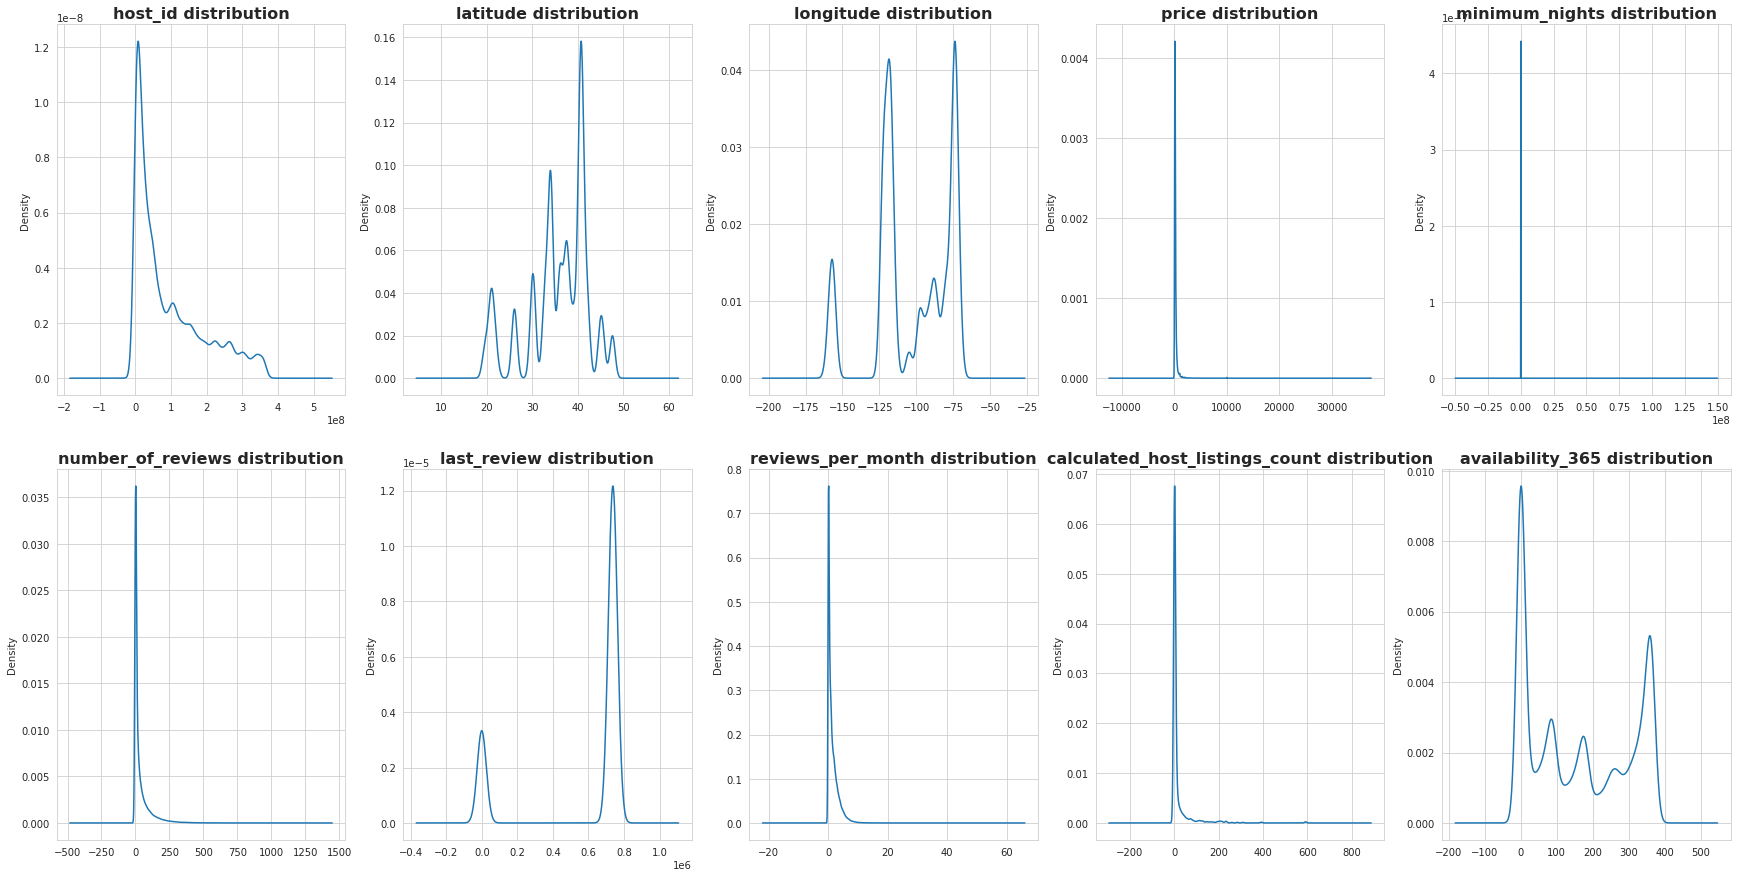

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5) 

fig.set_figwidth(30)
fig.set_figheight(15)

i = 0
for row in axes:
    for col in row:
        ab1[numerical_cols[i]].plot(kind='kde',ax=col)
        col.set_title(numerical_cols[i] +' distribution',fontsize=16,fontweight='bold')
        i+=1

In [ ]:
#remove outliers
imbalanced_columns = ['price','minimum_nights','calculated_host_listings_count',
          'reviews_per_month', 'number_of_reviews','last_review']

for col in imbalanced_columns:
    limit = ab1[col].quantile(0.90)
    print('95% of',col, 'values are under ',limit)
    ab1 = ab1[ab1[col]<limit]

# drop null price

ab1 = ab1[ab1.price.isnull() != True]
ab1 = ab1.drop('token', axis=1)

95% of price values are under  299.0
95% of minimum_nights values are under  5.0
95% of calculated_host_listings_count values are under  14.0
95% of reviews_per_month values are under  3.1399999999999997
95% of number_of_reviews values are under  79.0
95% of last_review values are under  737653.0


KeyError: ignored

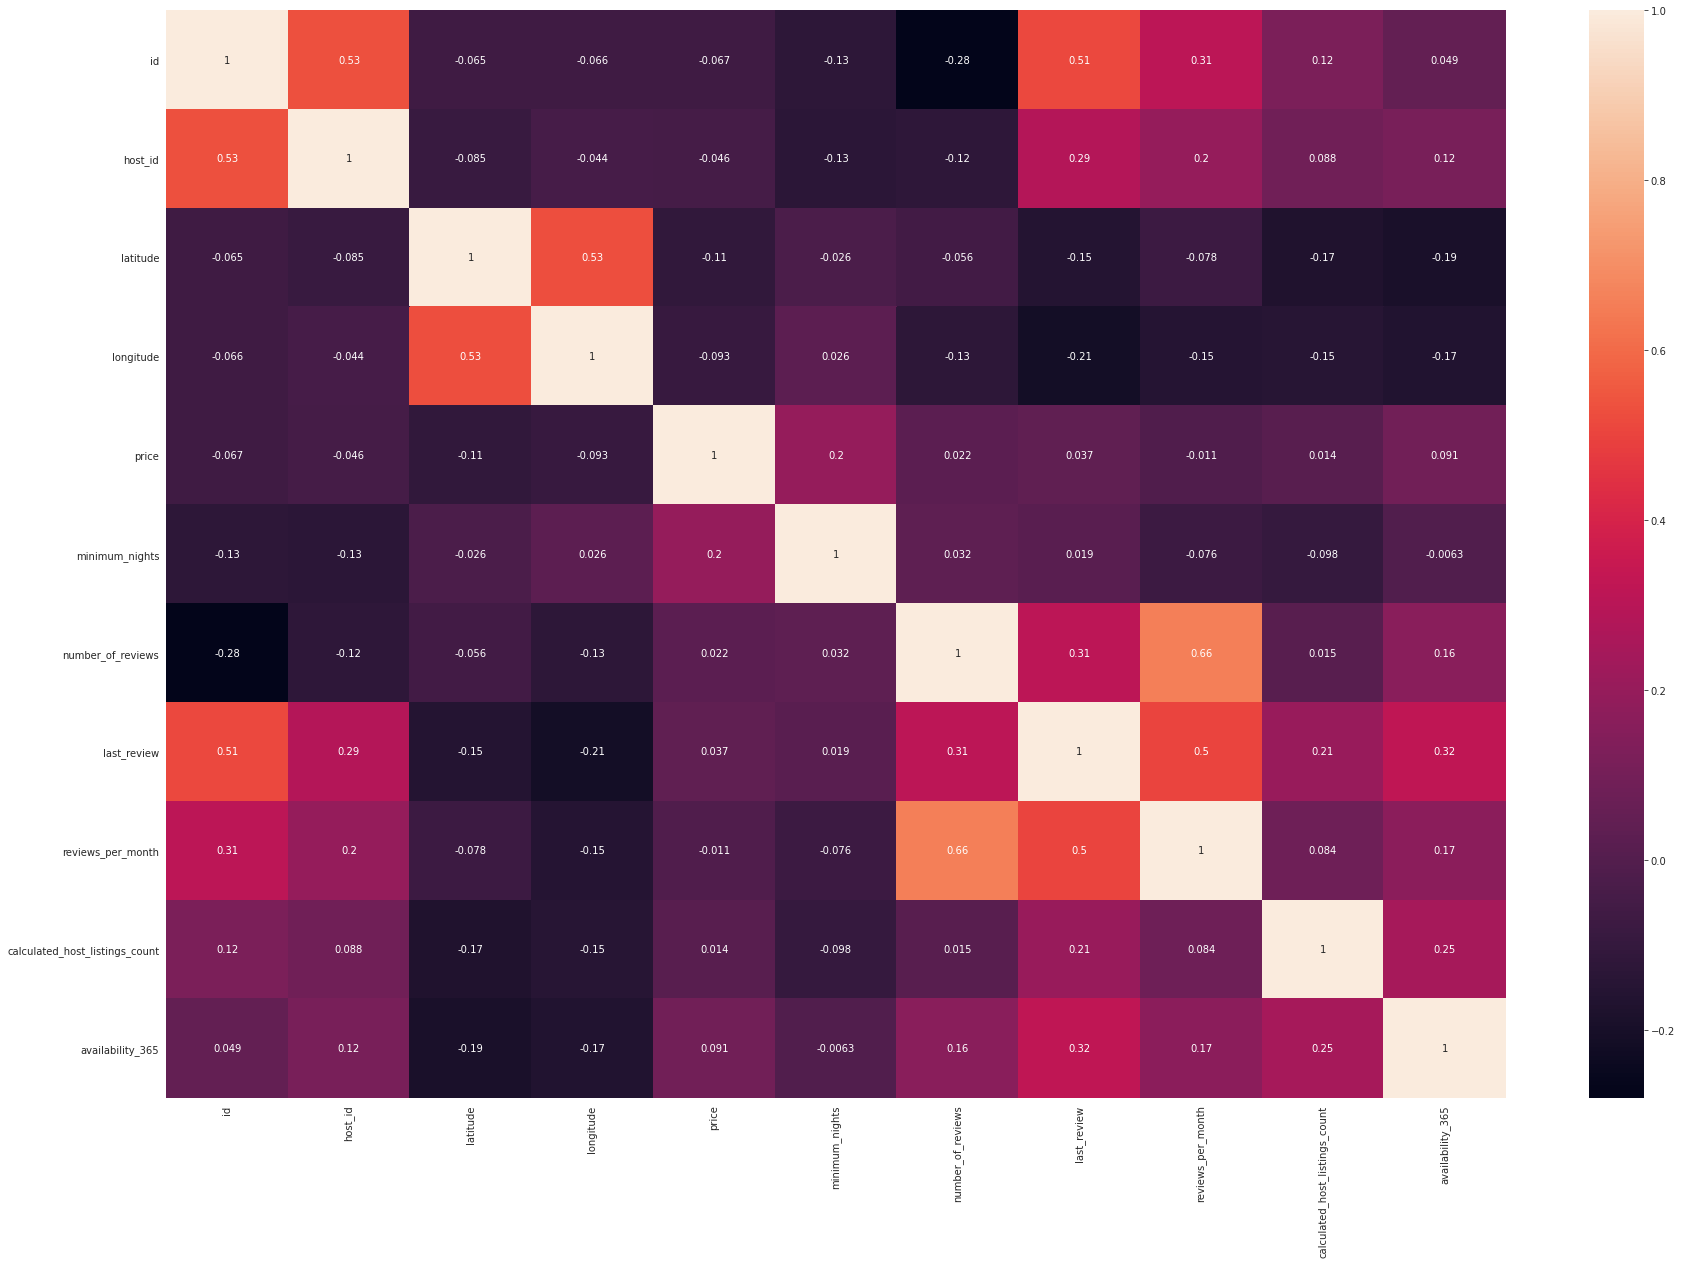

In [ ]:
#correlation matrix
corr = ab1.corr()
plt.figure(figsize = (30, 20))
sns.heatmap(corr, annot = True)
plt.show()

In [ ]:
ab1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,high_freq
7,246315,asheville dreamers cabin,1292070,Annie,Others,28805,35.59635,-82.50655,Private room,65,3,57,737362,0.53,2,106,Asheville,Null
20,634319,private asheville cabin apartment,1202653,Jim And Jan,Others,28805,35.62839,-82.47989,Entire home/apt,150,3,30,737068,0.31,1,266,Asheville,private
25,723349,blue ridge room at oakland cottage bb,3736218,Mary,Others,28801,35.57468,-82.55705,Private room,169,2,7,737619,0.09,7,0,Asheville,room
51,1392363,explorers retreat near downtown asheville,7527127,Theo,Others,28804,35.62447,-82.57928,Entire home/apt,202,3,32,737478,1.23,2,58,Asheville,near
55,1563004,sunny sublet in intentional community,8316714,Sivanne,Others,28806,35.57279,-82.60014,Private room,85,1,1,737425,0.11,1,0,Asheville,Null
